# Compare different scikit learn classifiers

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import decomposition
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
from IPython.display import clear_output
import timeit
import seaborn as sns



## Compare Classifier Performances

### Load the data into a datasets holder that will be passed into classifier comparison script

In [7]:
# Designate subjects to test
subjects_to_test = range(5)

# initialize empty datasets holder
datasets = [] 

# iterate through subjects_to_test, loading df into datasets holder
for subj in subjects_to_test:
    
    # Load subject data
    df = pd.read_csv('%i_all_task.csv'%subj, index_col=0)

    # Task exclusion
    exclude_task_nums = [1,3,4,5,6,7]
    df = df[~(df['task_num'].isin(exclude_task_nums))] 
    
    # Make new column: RestOrTask
    df['RestOrTask']=df['task_num']
    df.loc[df['RestOrTask']>0, 'RestOrTask']=1

        
    
    #######################################################################################
    ######### Uncomment this section for binary classifaction: rest or task state #########
    #######################################################################################
    # Subset to minimum number of trials per task state (Rest Or Task)
    num_trials = []
    for task_num_ind in np.unique(df.RestOrTask):
        num_trials.append(df[df['RestOrTask']==task_num_ind].shape[0])

    df_sub = df.iloc[0:1,:] # initialize a 1-row dataframe for concatenation

    for task_num_ind in np.unique(df.RestOrTask):
        df_temp = df[df['RestOrTask']==task_num_ind].sample(min(num_trials),axis=0)
        df_sub = pd.concat((df_sub, df_temp),axis=0)

    df_sub = df_sub.iloc[1:] # remove the initialized row
    
    # Identify original features and labels
    X = df_sub.loc[:,'R_V1':'L_p24']
    y = df_sub.loc[:,'RestOrTask']
    
    
    
    #######################################################################################
    ######### Uncomment this section for full task classifaction: 8 states total ##########
    #######################################################################################
#     # Subset to minimum number of trials per task
#     num_trials = []
#     for task_num_ind in np.unique(df.task_num):
#         num_trials.append(df[df['task_num']==task_num_ind].shape[0])

#     df_sub = df.iloc[0:1,:] # initialize a 1-row dataframe for concatenation

#     for task_num_ind in np.unique(df.task_num):
#         df_temp = df[df['task_num']==task_num_ind].sample(min(num_trials),axis=0)
#         df_sub = pd.concat((df_sub, df_temp),axis=0)

#     df_sub = df_sub.iloc[1:] # remove the initialized row
    
#     # Identify original features and labels
#     X = df_sub.loc[:,'R_V1':'L_p24']
#     y = df_sub.loc[:,'task_num']



    # PCA to reduce feature dimensions to 2
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)
    X = pca.transform(X)
    X = X[:,0:2]
    datasets.append((X,y))



### Classifier comparison script. Loops over contents of datasets (subjects) and loops over different classifiers

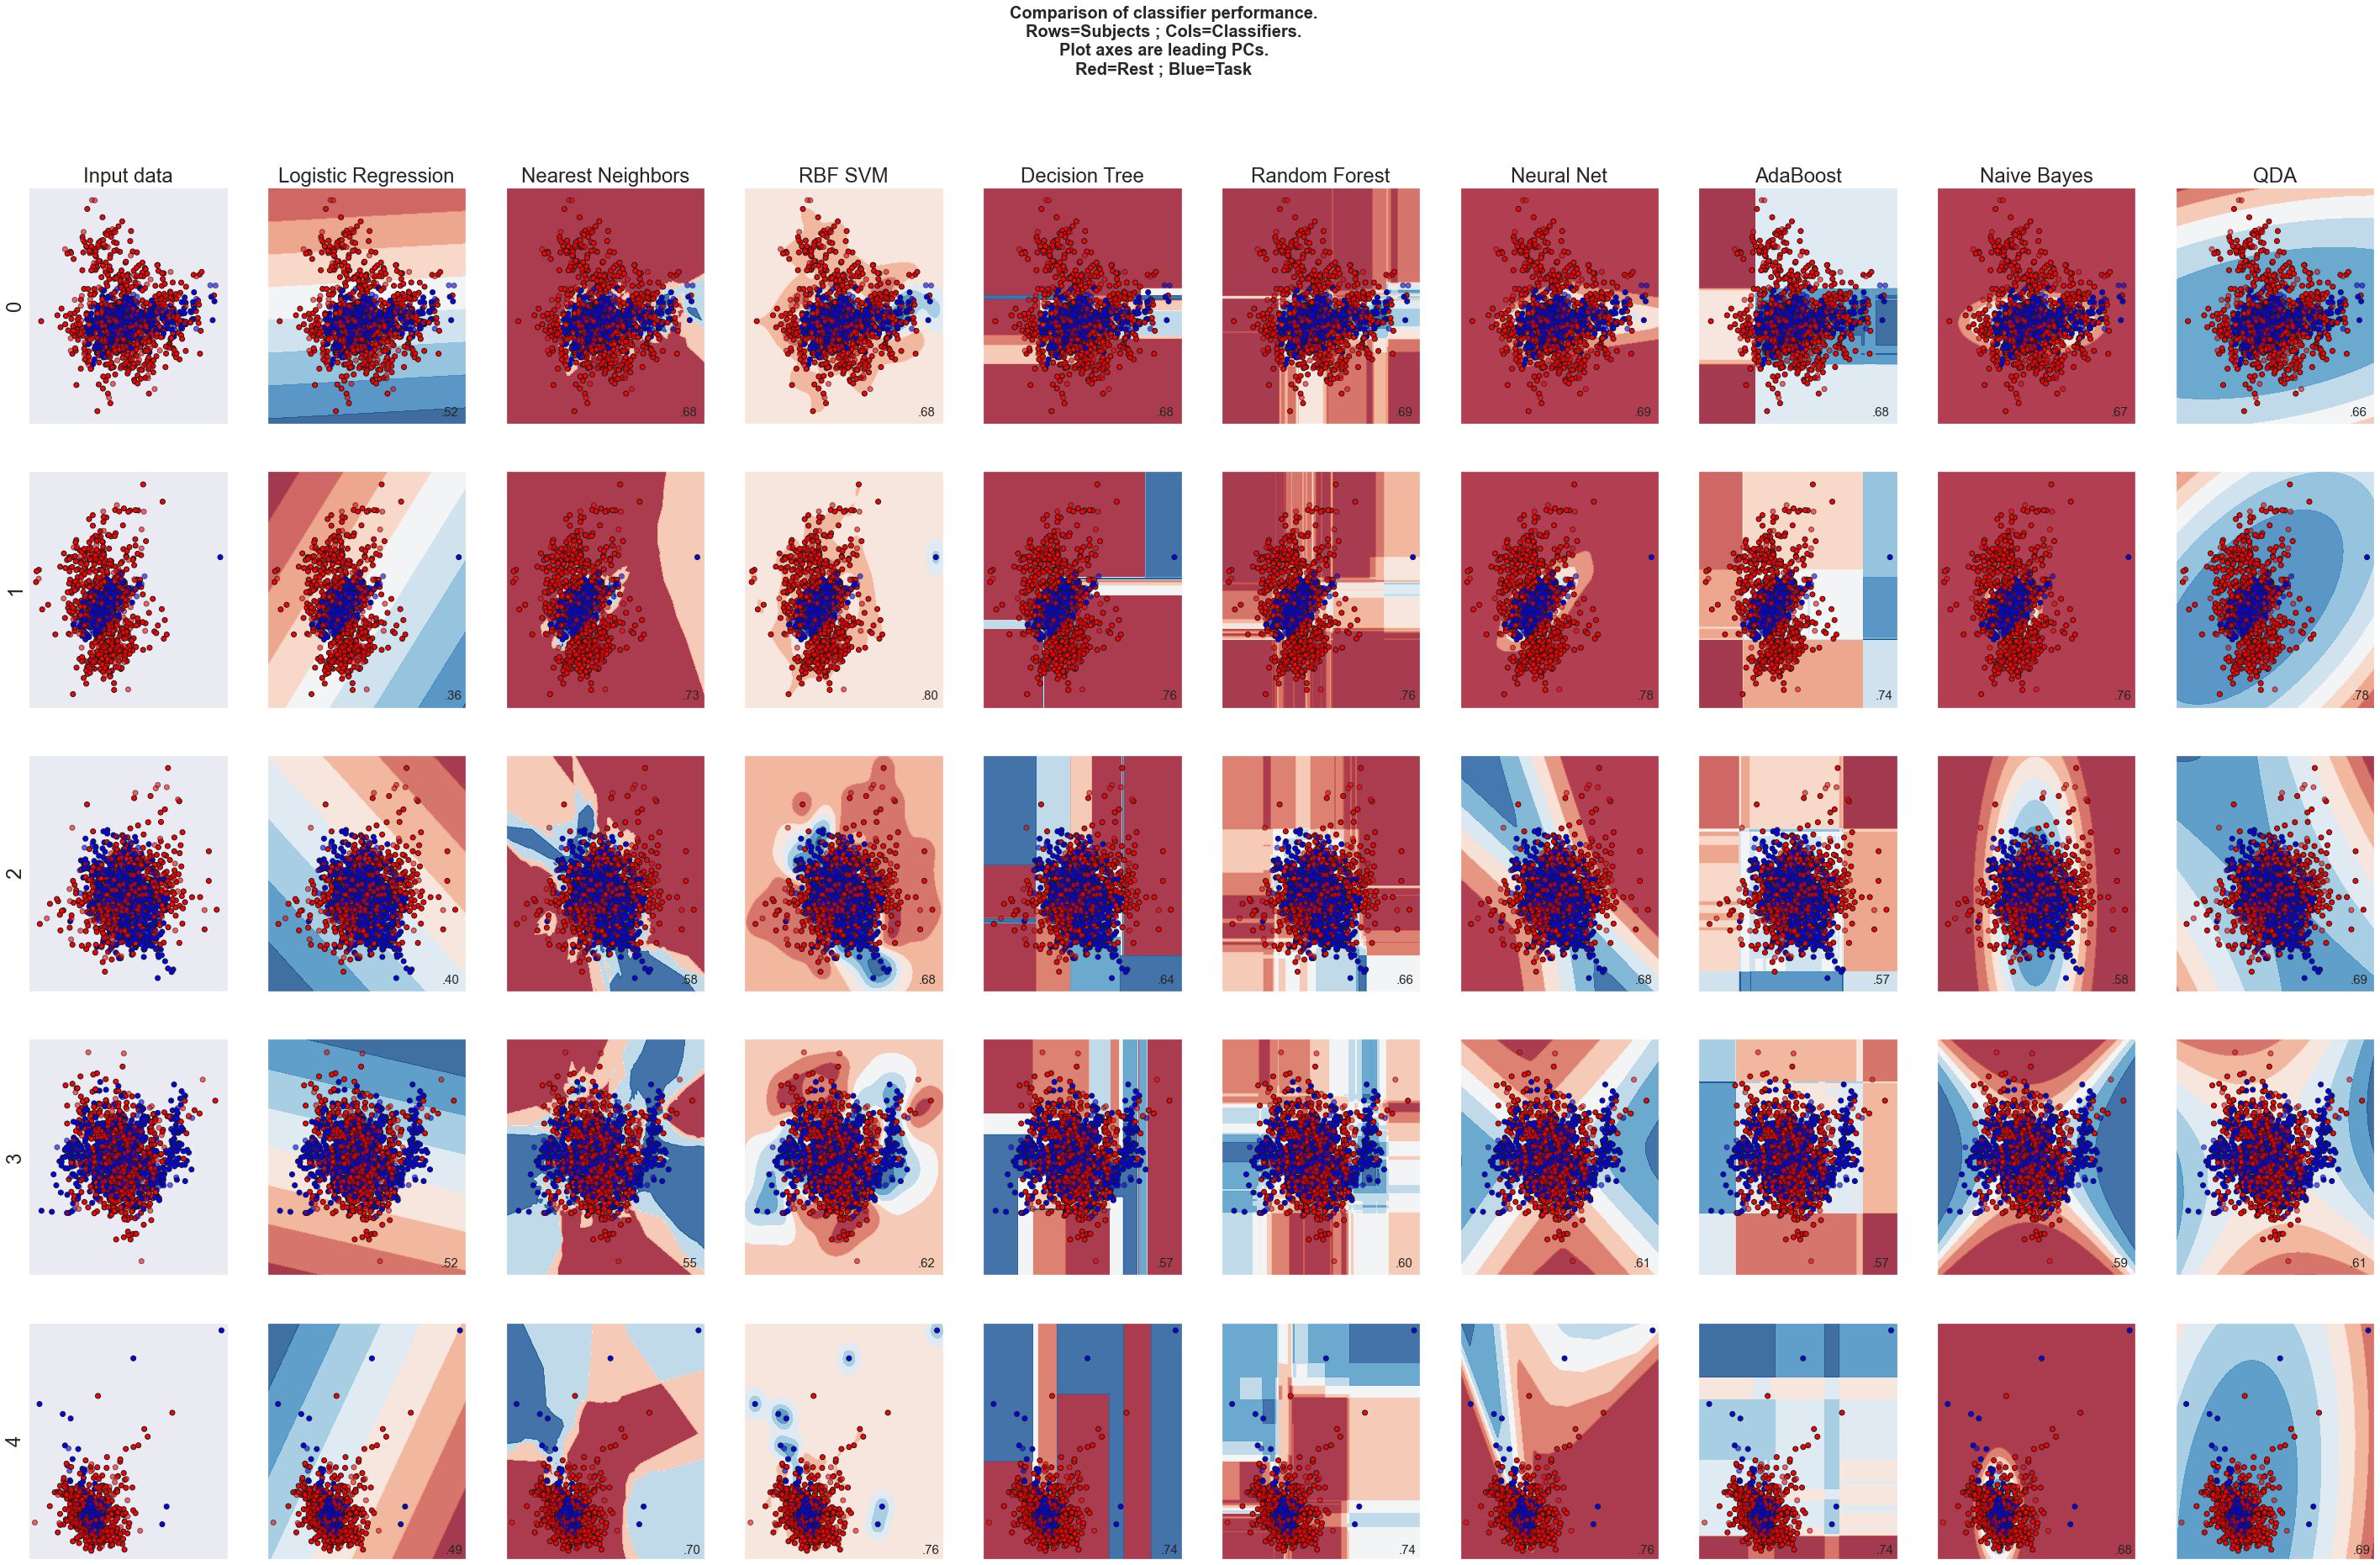

In [13]:
classifiers = [
        LogisticRegression(),
        KNeighborsClassifier(3),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
h = .02  # step size in the mesh
figure = plt.figure(figsize=(50, 30),facecolor='white')
figure.suptitle('Comparison of classifier performance.\nRows=Subjects ; Cols=Classifiers.\nPlot axes are leading PCs.\nRed=Rest ; Blue=Task',fontsize=20, fontweight='bold')

i = 1
sns.set(font_scale=2)

for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
#     cm_bright = ListedColormap(['#FF0000', '#0000FF', '#000FFF', '#00FFFF', '#0FFFFF', '#F000FF', '#FF00FF', '#FFF0FF'])
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#     cm_bright = ListedColormap(['blue', 'red'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_ylabel(ds_cnt)
    i += 1
    
    
####################################################################################
######### Fast list of classifiers #################################################
####################################################################################
    names = ["Logistic Regression", "Nearest Neighbors","RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

    classifiers = [
        LogisticRegression(),
        KNeighborsClassifier(3),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    
####################################################################################
######### List of classifiers plus logistic regression #############################
####################################################################################
#     names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
#          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#          "Naive Bayes", "QDA"]

#     classifiers = [
#         LogisticRegression(),
#         KNeighborsClassifier(3),
#         SVC(kernel="linear", C=0.025),
#         SVC(gamma=2, C=1),
#         GaussianProcessClassifier(1.0 * RBF(1.0)),
#         DecisionTreeClassifier(max_depth=5),
#         RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#         MLPClassifier(alpha=1, max_iter=1000),
#         AdaBoostClassifier(),
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis()]
    
    
####################################################################################
######### Original list of classifiers #############################################
####################################################################################
#     names = ["Nearest Neighbors", "RBF SVM", "Gaussian Process",
#          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#          "Naive Bayes", "QDA"]

#     classifiers = [
#         KNeighborsClassifier(3),
#         SVC(gamma=2, C=1),
#         GaussianProcessClassifier(1.0 * RBF(1.0)),
#         DecisionTreeClassifier(max_depth=5),
#         RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#         MLPClassifier(alpha=1, max_iter=1000),
#         AdaBoostClassifier(),
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis()]



    for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
#             print(round(score,4))

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):                
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#                 Z = np.zeros_like(xx)
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]


            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # Plot the testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1

In [14]:
figure.savefig('classifier_performance_wm_vs_rest.png')

## Just make one big KNN decision space figure

In [ ]:
subj = 2
datasets = []
# Load subject data
df = pd.read_csv('%i_all_task.csv'%subj, index_col=0)

# Task exclusion
exclude_task_nums = [1,3,4,5,6,7]
df = df[~(df['task_num'].isin(exclude_task_nums))] 

# Make new column: RestOrTask
df['RestOrTask']=df['task_num']
df.loc[df['RestOrTask']>0, 'RestOrTask']=1



#######################################################################################
######### Uncomment this section for binary classifaction: rest or task state #########
#######################################################################################
# Subset to minimum number of trials per task state (Rest Or Task)
num_trials = []
for task_num_ind in np.unique(df.RestOrTask):
    num_trials.append(df[df['RestOrTask']==task_num_ind].shape[0])

df_sub = df.iloc[0:1,:] # initialize a 1-row dataframe for concatenation

for task_num_ind in np.unique(df.RestOrTask):
    df_temp = df[df['RestOrTask']==task_num_ind].sample(min(num_trials),axis=0)
    df_sub = pd.concat((df_sub, df_temp),axis=0)

df_sub = df_sub.iloc[1:] # remove the initialized row

# Identify original features and labels
X = df_sub.loc[:,'R_V1':'L_p24']
y = df_sub.loc[:,'RestOrTask']

# PCA to reduce feature dimensions to 2
pca = decomposition.PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)
X = X[:,0:2]
datasets.append((X,y))
    
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20, 10),facecolor='white')

i = 1

for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

#     # just plot the dataset first
#     cm = plt.cm.RdBu
# #     cm_bright = ListedColormap(['#FF0000', '#0000FF', '#000FFF', '#00FFFF', '#0FFFFF', '#F000FF', '#FF00FF', '#FFF0FF'])
#     cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# #     cm_bright = ListedColormap(['blue', 'red'])
#     ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
#     if ds_cnt == 0:
#         ax.set_title("Input data")
#     # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
#     # Plot the testing points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
#                edgecolors='k')
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     ax.set_ylabel(ds_cnt)
#     i += 1
    
    
####################################################################################
######### Fast list of classifiers #################################################
####################################################################################
    names = ["K Nearest Neighbors Classification Space\nRed=Resting State\nBlue=Working Memory Task"]

    classifiers = [
        KNeighborsClassifier(3)]


    for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
#             print(round(score,4))

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):                
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#                 Z = np.zeros_like(xx)
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]


            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # Plot the testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_xlabel('Principle Component 1')
            ax.set_ylabel('Principle Component 2')
            plt.rc('font', size=20)
            plt.rc('axes', titlesize=20)     # fontsize of the axes title
            plt.rc('axes', labelsize=20) 
            if ds_cnt == 0:
                ax.set_title(name)
#             ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#                     size=15, horizontalalignment='right')
            i += 1